In [37]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from tqdm import tqdm
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import tensorflow as tf
from tensorflow.keras.applications import ResNet50, InceptionV3
from tensorflow.keras.layers import (Input, Conv2D, BatchNormalization, Activation, MaxPooling2D,
                                     GlobalAveragePooling2D, Dense, Dropout, Add, Flatten, Layer)
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau,ModelCheckpoint
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [4]:
def load_images_from_directory(directory, label):
    data = []
    labels = []
    filenames = []

    for filename in tqdm(os.listdir(directory), desc=f"Loading {directory}"):
        filepath = os.path.join(directory, filename)
        with Image.open(filepath) as img:
            img = img.convert('L')  # Convert to grayscale
            img = img.resize((256, 256))  # Resize to 256x256 pixels
            img_array = np.array(img)
            data.append(img_array)
            labels.append(label)
            filenames.append(filename)

    return np.array(data), np.array(labels), filenames

In [5]:
# Directories
yes_nosied_directory = 'C:/Users/limvi/Desktop/FYP1/BrainTumorDataset-Noised/yes'
no_noised_directory = 'C:/Users/limvi/Desktop/FYP1/BrainTumorDataset-Noised/no'

In [6]:
# Load data
yes_noised_data, yes_noised_labels, yes_noised_filenames = load_images_from_directory(yes_nosied_directory, 1)  # 1 for tumor
no_noised_data, no_noised_labels, no_noised_filenames = load_images_from_directory(no_noised_directory, 0)  # 0 for no tumor

Loading C:/Users/limvi/Desktop/FYP1/BrainTumorDataset-Noised/yes: 100%|██████████| 155/155 [00:00<00:00, 705.71it/s]
Loading C:/Users/limvi/Desktop/FYP1/BrainTumorDataset-Noised/no: 100%|██████████| 155/155 [00:00<00:00, 772.01it/s]


In [7]:
# Function to crop images based on contours
def contour_cropping(images, add_pixels_value=0, target_size=(256, 256)):
    cropped_images = []
    for img in images:
        # Ensure img is a numpy array with dtype 'uint8'
        img = img.astype(np.uint8)
        blurred = cv2.GaussianBlur(img, (5, 5), 0)
        _, thresh = cv2.threshold(blurred, 45, 255, cv2.THRESH_BINARY)
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if contours:
            largest_contour = max(contours, key=cv2.contourArea)
            x, y, w, h = cv2.boundingRect(largest_contour)
            x_start = max(0, x - add_pixels_value)
            y_start = max(0, y - add_pixels_value)
            x_end = min(img.shape[1], x + w + add_pixels_value)
            y_end = min(img.shape[0], y + h + add_pixels_value)
            cropped_image = img[y_start:y_end, x_start:x_end]
        else:
            # If no contours are found, use the original image
            cropped_image = img

        # Resize cropped image to the target size
        resized_image = cv2.resize(cropped_image, target_size)
        cropped_images.append(resized_image)

    return np.array(cropped_images)

In [8]:
# Optionally apply contour cropping
yes_noised_cropped_data = contour_cropping(yes_noised_data)
no_noised_cropped_data = contour_cropping(no_noised_data)

In [9]:
# Combine the datasets
X = np.concatenate((yes_noised_cropped_data, no_noised_cropped_data))
y = np.concatenate((yes_noised_labels, no_noised_labels))

In [10]:
# First split: Separate 70% for training and 30% for temp (validation + test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Second split: Divide the temp data equally into validation and test sets (50% each of 30% => 15% each)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

In [11]:
# Add a channel dimension to indicate grayscale
X_train = np.expand_dims(X_train, axis=-1)  # Add a new axis at the end
X_val = np.expand_dims(X_val, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

# Print the shapes of the datasets to verify the new dimensions
print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Test set shape:", X_test.shape, y_test.shape)

Training set shape: (217, 256, 256, 1) (217,)
Validation set shape: (46, 256, 256, 1) (46,)
Test set shape: (47, 256, 256, 1) (47,)


In [12]:
# Create image data generators for training and testing
# Normalizing and augmenting only the training data
train_datagen = ImageDataGenerator(
    rescale=1./255, # Normalize pixel values
    rotation_range=15,# Random rotations
    width_shift_range=0.05,# Random horizontal shifts
    height_shift_range=0.05,# Random vertical shifts
    shear_range=0.05,# Shear transformations
    zoom_range=0.05,# Random zoom
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,# Horizontal flipping
     vertical_flip=True,# Vertical flipping
    fill_mode='nearest' # Strategy for filling in newly created pixels
)

# Only rescale validation and test data
test_val_datagen = ImageDataGenerator(rescale=1./255)

# Prepare iterators
train_generator = train_datagen.flow(X_train, y_train, batch_size=32,shuffle=True)
val_generator = test_val_datagen.flow(X_val, y_val, batch_size=32,shuffle=False)
test_generator = test_val_datagen.flow(X_test, y_test, batch_size=32,shuffle=False)


In [33]:
# Define custom GrayToRGB layer
class GrayToRGB(Layer):
    def __init__(self):
        super(GrayToRGB, self).__init__()
    def call(self, inputs):
        return tf.image.grayscale_to_rgb(inputs)

# Model setup
input_layer = Input(shape=(256, 256, 1))
rgb_layer = GrayToRGB()(input_layer)
inception_base = InceptionV3(include_top=False, weights='imagenet', input_tensor=rgb_layer)

# Unfreeze the top layers of the base model
for layer in inception_base.layers[-50:]:  # Unfreeze the last 50 layers
    layer.trainable = True

x = GlobalAveragePooling2D()(inception_base.output)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
output_layer = Dense(1, activation='sigmoid')(x)  # Binary classification

# Compile model
model_inceptionv3 = Model(inputs=input_layer, outputs=output_layer)
model_inceptionv3.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Print summary
model_inceptionv3.summary()



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 gray_to_rgb (GrayToRGB)     (None, 256, 256, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv2d (Conv2D)             (None, 127, 127, 32)         864       ['gray_to_rgb[0][0]']         
                                                                                                  
 batch_normalization (Batch  (None, 127, 127, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                             

In [39]:
# Model training
history = model_inceptionv3.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True),
        ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True)
    ]
)

Epoch 1/20


7/7 [==============================] - 32s 3s/step - loss: 0.9350 - accuracy: 0.5899 - val_loss: 0.6750 - val_accuracy: 0.6087
Epoch 2/20
7/7 [==============================] - 12s 2s/step - loss: 0.7434 - accuracy: 0.6359 - val_loss: 0.6249 - val_accuracy: 0.6957
Epoch 3/20
7/7 [==============================] - 12s 2s/step - loss: 0.5718 - accuracy: 0.7143 - val_loss: 0.5870 - val_accuracy: 0.7391
Epoch 4/20
7/7 [==============================] - 12s 2s/step - loss: 0.4745 - accuracy: 0.7742 - val_loss: 0.5598 - val_accuracy: 0.7609
Epoch 5/20
7/7 [==============================] - 11s 2s/step - loss: 0.4789 - accuracy: 0.7972 - val_loss: 0.5533 - val_accuracy: 0.7609
Epoch 6/20
7/7 [==============================] - 11s 2s/step - loss: 0.3126 - accuracy: 0.8710 - val_loss: 0.5390 - val_accuracy: 0.7609
Epoch 7/20
7/7 [==============================] - 11s 2s/step - loss: 0.4249 - accuracy: 0.8157 - val_loss: 0.5146 - val_accuracy: 0.7391
Epoch 8/20
7/7 [================

2/2 [==============================] - 1s 222ms/step - loss: 0.3584 - accuracy: 0.8298
Test Loss: 0.3583841919898987
Test Accuracy: 0.8297872543334961
2/2 [==============================] - 1s 160ms/step


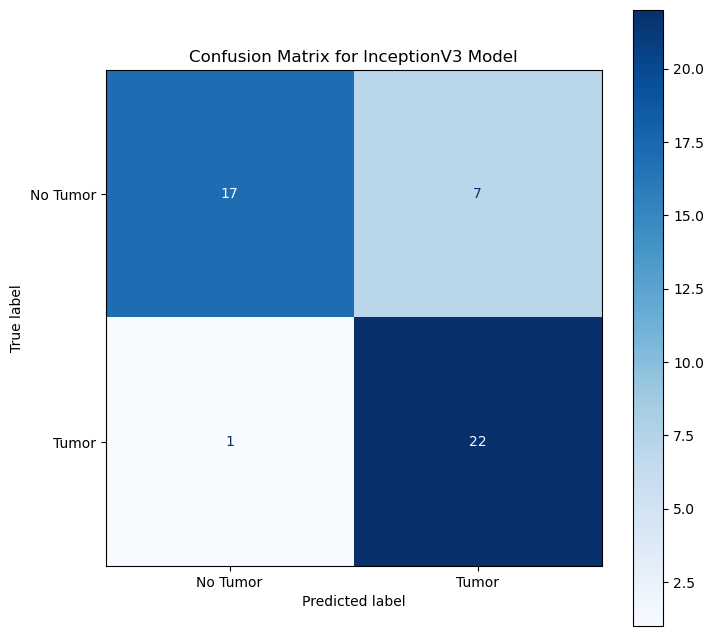

Classification Report for InceptionV3 Model:
               precision    recall  f1-score   support

    No Tumor       0.94      0.71      0.81        24
       Tumor       0.76      0.96      0.85        23

    accuracy                           0.83        47
   macro avg       0.85      0.83      0.83        47
weighted avg       0.85      0.83      0.83        47



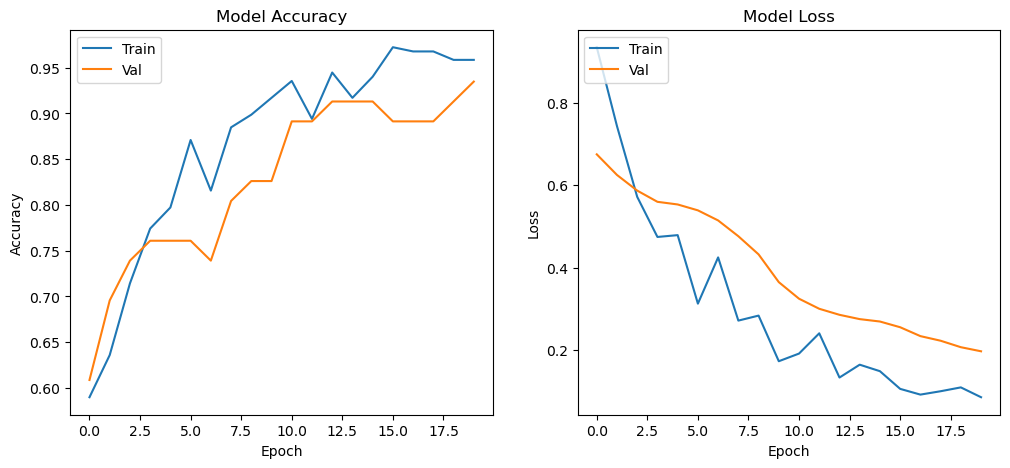

In [43]:
# Evaluate the model on the test data
test_metrics_inceptionv3 = model_inceptionv3.evaluate(test_generator)
print('Test Loss:', test_metrics_inceptionv3[0])
print('Test Accuracy:', test_metrics_inceptionv3[1])

# Generate predictions
true_classes_inceptionv3 = y_test
predictions_inceptionv3= model_inceptionv3.predict(test_generator)
predicted_classes_inceptionv3 = (predictions_inceptionv3> 0.5).astype(int).flatten()

# Compute the confusion matrix
conf_matrix_inceptionv3 = confusion_matrix(true_classes_inceptionv3, predicted_classes_inceptionv3)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(8, 8))
disp = ConfusionMatrixDisplay(conf_matrix_inceptionv3, display_labels=['No Tumor', 'Tumor'])
disp.plot(cmap=plt.cm.Blues, ax=ax)
ax.set_title('Confusion Matrix for InceptionV3 Model')
plt.show()

# Generate the classification report
report_inceptionv3 = classification_report(true_classes_inceptionv3, predicted_classes_inceptionv3, target_names=['No Tumor', 'Tumor'])
print("Classification Report for InceptionV3 Model:\n", report_inceptionv3)

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.show()
